In [1]:
import os
import pandas as pd
from scipy.signal import butter, filtfilt

folder_path = '../datasets/fastStorage/2013-8'

# List all CSV files in the folder
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

dfs = []
cutoff_frequency = 0.1
sampling_rate = 1
filter_order = 5

def lowpass_filter(data, cutoff, fs, order):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    
    if data.shape[0] > order * 3:
        y = filtfilt(b, a, data, axis=0)
    else:
        y = data
    return y

for file in csv_files:
    # Load the CSV file into a DataFrame
    df = pd.read_csv(os.path.join(folder_path, file), delimiter=';')
    df = df[['\tCPU usage [%]', '\tMemory usage [KB]', '\tDisk read throughput [KB/s]', '\tDisk write throughput [KB/s]', '\tNetwork received throughput [KB/s]', '\tNetwork transmitted throughput [KB/s]']]
    # Remove the \t from the header of all columns
    df.columns = df.columns.str.replace('\t', '')
    df.fillna(0, inplace=True) 

    filtered_data = lowpass_filter(df.values, cutoff_frequency, sampling_rate, filter_order)
    df_filtered = pd.DataFrame(filtered_data, columns=df.columns)
    dfs.append(df_filtered)


In [2]:

# Find the Xth percentile of the dfs size
percentile = 0.1
sizes = [df.shape[0] for df in dfs]
df_min_size = int(pd.Series(sizes).quantile(percentile))
print(f'{(1-percentile) * 100}% of dfs are above: {df_min_size} rows')

# Remove dfs below the Xth percentile
dfs = [df for df in dfs if df.shape[0] > df_min_size]

# Remove the first Y rows of each df (because they are not stable)
rows_to_skip = 1000

# Keep only the first X rows of each df (skip the first Y rows)
dfs = [df.iloc[rows_to_skip:rows_to_skip+df_min_size] for df in dfs]
dfs_size = df_min_size - rows_to_skip

dfs_columns = dfs[0].columns




90.0% of dfs are above: 8612 rows


### 1. Basic Statistical Features

* **Mean, Median, Mode**: Basic statistical measures of central tendency.
* **Standard Deviation**, Variance: Measures of data dispersion or spread.
* **Min, Max, range**: Extreme values in your data series.
* **Percentiles (median, 25th, 75th), interquartile range**: Quantiles.
* **Skewness, Kurtosis**: Measures of the asymmetry and peakedness of the distribution of values.
* **Sum**: Total value, which can be especially relevant for resource consumption over time


In [3]:

import scipy.stats

import numpy as np

dfs_simple_stats = []

# Process each CSV file
for i, df in enumerate(dfs):

    # Create a DataFrame to store the statistics
    df_stats = pd.DataFrame(index=['mean', 'std', 'variance', 'max', 'min', 'range', 'skewness', 'kurtosis', 'median', 'percentile_25', 'percentile_75', 'iqr', 'lower_bound', 'upper_bound', 'n_outliers', 'n_nan', 'n_unique', 'n_zeros', 'n_negatives', 'n_positives', 'n_above_mean', 'n_below_mean', 'n_above_upper_bound', 'n_below_lower_bound'])
    
    # Calculate statistics for each feature
    for column in dfs_columns:

        # Calculate the mean
        var_mean = df[column].mean()
        # Calculate the standard deviation
        var_std = df[column].std()
        # Calculate the mode
        #mode = df.mode()
        #print(df[column].shape)
        #print(mode)
        # Calculate the variance
        var_variance = df[column].var()
        # Calculate the max
        var_max = df[column].max()
        # Calculate the min
        var_min = df[column].min()
        # Calculate the range
        var_range = var_max - var_min
        # Calculate the skewness
        var_skewness = df[column].skew()
        # Calculate the kurtosis
        var_kurtosis = df[column].kurtosis()
        # Calculate the median
        var_median = df[column].median()
        # Calculate the 25th percentile
        var_percentile_25 = df[column].quantile(0.25)
        # Calculate the 75th percentile
        var_percentile_75 = df[column].quantile(0.75)
        # Calculate the interquartile range
        var_iqr = var_percentile_75 - var_percentile_25
        # Calculate the lower bound
        var_lower_bound = var_percentile_25 - 1.5 * var_iqr
        # Calculate the upper bound
        var_upper_bound = var_percentile_75 + 1.5 * var_iqr
        # Calculate the number of outliers
        var_n_outliers = df[column][(df[column] < var_lower_bound) | (df[column] > var_upper_bound)].count()
        # Calculate the number of NaN values
        var_n_nan = df[column].isna().sum()
        # Calculate the number of unique values
        var_n_unique = df[column].nunique()
        # Calculate the number of zero values
        var_n_zeros = df[column][df[column] == 0].count()
        # Calculate the number of negative values
        var_n_negatives = df[column][df[column] < 0].count()
        # Calculate the number of positive values
        var_n_positives = df[column][df[column] > 0].count()
        # Calculate the number of values above the mean
        var_n_above_mean = df[column][df[column] > var_mean].count()
        # Calculate the number of values below the mean
        var_n_below_mean = df[column][df[column] < var_mean].count()
        # Calculate the number of values above the upper bound
        var_n_above_upper_bound = df[column][df[column] > var_upper_bound].count()
        # Calculate the number of values below the lower bound
        var_n_below_lower_bound = df[column][df[column] < var_lower_bound].count()
        # Save as to stats df
        df_stats[column] = [var_mean, var_std, var_variance, var_max, var_min, var_range, var_skewness, var_kurtosis, var_median, var_percentile_25, var_percentile_75, var_iqr, var_lower_bound, var_upper_bound, var_n_outliers, var_n_nan, var_n_unique, var_n_zeros, var_n_negatives, var_n_positives, var_n_above_mean, var_n_below_mean, var_n_above_upper_bound, var_n_below_lower_bound]
        

    #print(df_stats)
    dfs_simple_stats.append(df_stats)
    #break        

    # Print percentage done each 1% of the way
    if i % (len(dfs) // 100) == 0:
        print(f'{(i / len(dfs)) * 100}% done')


0.0% done
0.9225092250922509% done
1.8450184501845017% done
2.7675276752767526% done
3.6900369003690034% done
4.612546125461255% done
5.535055350553505% done
6.4575645756457565% done
7.380073800738007% done
8.302583025830259% done
9.22509225092251% done
10.14760147601476% done
11.07011070110701% done
11.992619926199263% done
12.915129151291513% done
13.837638376383765% done
14.760147601476014% done
15.682656826568268% done
16.605166051660518% done
17.52767527675277% done
18.45018450184502% done
19.37269372693727% done
20.29520295202952% done
21.217712177121772% done
22.14022140221402% done
23.062730627306273% done
23.985239852398525% done
24.907749077490777% done
25.830258302583026% done
26.752767527675275% done
27.67527675276753% done
28.59778597785978% done
29.520295202952028% done
30.44280442804428% done
31.365313653136536% done
32.28782287822878% done
33.210332103321036% done
34.132841328413285% done
35.05535055350554% done
35.97785977859779% done
36.90036900369004% done
37.8228782

**Old version**

In [21]:

import scipy.stats

import numpy as np

# Define the path to the folder containing the CSV files
folder_path = '../datasets/fastStorage/2013-8'

# Initialize a dictionary to store aggregated stats
simple_stats_dict = {}

# Process each CSV file
for df in dfs:

    df.columns = df.columns.str.strip()
    
    # Calculate statistics for each feature
    for column in df.columns:
        # Initialize the column in the dictionary if not already present
        if column not in simple_stats_dict:
            simple_stats_dict[column] = {"Mean": [], "Median": [], "Mode": [], "Standard Deviation": [], "Variance": [], 
                                        "Min": [], "Max": [], "Range": [], "25th Percentile": [], "50th Percentile": [], "75th Percentile": [],
                                        "Interquartile Range": [], "Skewness": [], "Kurtosis": [], "Sum": []}
        
        # Calculate and append statistics
        #simple_stats_dict[column]["Mean"].append(df[column].mean())
        #simple_stats_dict[column]["Median"].append(df[column].median())
        mode = df[column].mode()
        simple_stats_dict[column]["Mode"].append(mode[0] if not mode.empty else np.nan)
        #simple_stats_dict[column]["Standard Deviation"].append(df[column].std())
        simple_stats_dict[column]["Variance"].append(df[column].var())
        simple_stats_dict[column]["Min"].append(df[column].min())
        simple_stats_dict[column]["Max"].append(df[column].max())
        simple_stats_dict[column]["Range"].append(df[column].max() - df[column].min())
        #simple_stats_dict[column]["25th Percentile"].append(df[column].quantile(0.25))
        #simple_stats_dict[column]["50th Percentile"].append(df[column].quantile(0.50))
        #simple_stats_dict[column]["75th Percentile"].append(df[column].quantile(0.75))
        #simple_stats_dict[column]["Interquartile Range"].append(df[column].quantile(0.75) - df[column].quantile(0.25))
        #simple_stats_dict[column]["Skewness"].append(scipy.stats.skew(df[column]))
        #simple_stats_dict[column]["Kurtosis"].append(scipy.stats.kurtosis(df[column]))
        simple_stats_dict[column]["Sum"].append(df[column].sum())

# Convert the aggregated stats to a more friendly format (e.g., DataFrame) for reporting or further analysis
# Here's an example of converting the mean statistics to a DataFrame
all_stats_df = pd.DataFrame(simple_stats_dict)


In [51]:
# Initialize an empty list to hold all the flattened data
flattened_data = []

# Iterate over each feature in the aggregated_stats dictionary
for feature, stats in simple_stats_dict.items():
    # For each statistic in this feature, extract the list of values
    for stat_name, values in stats.items():
        # Iterate over each value in the list
        for value in values:
            # Create a dictionary for this observation
            # Assuming each value corresponds to a single observation across CSV files
            observation = {
                'Feature': feature,
                'Statistic': stat_name,
                'Value': value
            }
            # Append the observation to the flattened data list
            flattened_data.append(observation)

# Convert the flattened data list into a DataFrame
flattened_df = pd.DataFrame(flattened_data)


(11, 15)


### 2. Rolling / Window-Based Features
* **Rolling Averages**: Simple moving averages (SMA) with varied window sizes.
* **Rolling Volatility**: Rolling standard deviation.
* **Rolling Quantiles**: To capture how percentile metrics shift over time.
* **Bollinger Bands**: Combine a moving average with bands based on rolling volatility.

In [4]:
import pandas as pd
import numpy as np
from scipy.stats import norm  # For Bollinger Bands


# **Rolling Averages (SMA)**
def calculate_rolling_averages(df, column, window_sizes, df_windowed):

    for window_size in window_sizes:
        name = f'rolling-avg_{column}_window-size={window_size}'

        df_windowed[name] = df[column].rolling(window=window_size).mean()

# **Rolling Volatility**
def calculate_rolling_volatility(df, column, window_sizes, df_windowed):
    
    for window_size in window_sizes:

        name = f'rolling-std_{column}_window-size={window_size}'

        # Create a new column in the DataFrame to store the rolling average
        df_windowed[name] = df[column].rolling(window=window_size).std()


# **Rolling Quantiles**
def calculate_rolling_quantiles(df, column, window_sizes, df_windowed, quantiles=[0.25, 0.75]):

    for window_size in window_sizes:

        for q in quantiles:

            name = f'quantile={q}_{column}_window-size={window_size}'

            df_windowed[name] = df[column].rolling(window=window_size).quantile(q)

# **Bollinger Bands**
def calculate_bollinger_bands(column, window_sizes, df_windowed, num_std=2):

    for window_size in window_sizes:

        mean_name = f'rolling-avg_{column}_window-size={window_size}'
        std_name = f'rolling-std_{column}_window-size={window_size}'

        rolling_mean = df_windowed[mean_name]
        rolling_std = df_windowed[std_name]

        #print(rolling_mean)
        #print([mean + num_std*std for mean,std in zip(rolling_mean,rolling_std)])

        upper_band_name = f'upper-band_{column}_window-size={window_size}'
        lower_band_name = f'lower-band_{column}_window-size={window_size}'

        df_windowed[upper_band_name] = [mean + num_std*std for mean,std in zip(rolling_mean,rolling_std)]
        df_windowed[lower_band_name] = [mean - num_std*std for mean,std in zip(rolling_mean,rolling_std)]

dfs_windowed = []

window_sizes = [20]

for i, df in enumerate(dfs):

    # Create a DataFrame to store the windowed statistics
    df_windowed = pd.DataFrame(index=df.index)

    for column in dfs_columns:
        calculate_rolling_averages(df, column, window_sizes=window_sizes, df_windowed=df_windowed)
        calculate_rolling_volatility(df, column, window_sizes=window_sizes, df_windowed=df_windowed)
        calculate_rolling_quantiles(df, column, window_sizes=window_sizes, df_windowed=df_windowed)
        calculate_bollinger_bands(column, window_sizes=window_sizes, df_windowed=df_windowed)

    dfs_windowed.append(df_windowed)
    #break

    # Print percentage done each 1% of the way
    if i % (len(dfs) // 100) == 0:
        print(f'{(i / len(dfs)) * 100}% done')

    #for key, val in data_dict.items():
    #    print(key)
    #    print(val['\tCPU usage [%]'].iloc[30:50])


0.0% done
0.9225092250922509% done
1.8450184501845017% done
2.7675276752767526% done
3.6900369003690034% done
4.612546125461255% done
5.535055350553505% done
6.4575645756457565% done
7.380073800738007% done
8.302583025830259% done
9.22509225092251% done
10.14760147601476% done
11.07011070110701% done
11.992619926199263% done
12.915129151291513% done
13.837638376383765% done
14.760147601476014% done
15.682656826568268% done
16.605166051660518% done
17.52767527675277% done
18.45018450184502% done
19.37269372693727% done
20.29520295202952% done
21.217712177121772% done
22.14022140221402% done
23.062730627306273% done
23.985239852398525% done
24.907749077490777% done
25.830258302583026% done
26.752767527675275% done
27.67527675276753% done
28.59778597785978% done
29.520295202952028% done
30.44280442804428% done
31.365313653136536% done
32.28782287822878% done
33.210332103321036% done
34.132841328413285% done
35.05535055350554% done
35.97785977859779% done
36.90036900369004% done
37.8228782

In [8]:
print(dfs_windowed[0].columns)

Index(['rolling-avg_CPU usage [%]_window-size=5',
       'rolling-avg_CPU usage [%]_window-size=10',
       'rolling-avg_CPU usage [%]_window-size=20',
       'rolling-std_CPU usage [%]_window-size=5',
       'rolling-std_CPU usage [%]_window-size=10',
       'rolling-std_CPU usage [%]_window-size=20',
       'quantile=0.25_CPU usage [%]_window-size=5',
       'quantile=0.75_CPU usage [%]_window-size=5',
       'quantile=0.25_CPU usage [%]_window-size=10',
       'quantile=0.75_CPU usage [%]_window-size=10',
       ...
       'quantile=0.25_Network transmitted throughput [KB/s]_window-size=10',
       'quantile=0.75_Network transmitted throughput [KB/s]_window-size=10',
       'quantile=0.25_Network transmitted throughput [KB/s]_window-size=20',
       'quantile=0.75_Network transmitted throughput [KB/s]_window-size=20',
       'upper-band_Network transmitted throughput [KB/s]_window-size=5',
       'lower-band_Network transmitted throughput [KB/s]_window-size=5',
       'upper-band_Ne


### 3. Trend & Seasonality

* **Decomposition**: Break down your time series into trend, seasonal, and residual components (e.g., STL decomposition). Features can then be engineered from each component.
* **Autocorrelation Features**: Measures of how the signal correlates with itself at different lags, useful for identifying repeating patterns or periodicity.
* **Change Rates**: The rate of change between consecutive measurements or over specified intervals, capturing acceleration or deceleration in resource usage.

In [ ]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf


def decompose_timeseries(df, column, df_trends, period=1):
    """Decomposes a time series into trend, seasonal, and residual components using STL.

    Args:
        df (pd.DataFrame): The DataFrame containing the time series data.
        column (str): The name of the column containing the time series data.
        period (int, optional): The period of the seasonal component. Defaults to 1.

    Returns:
        pd.DataFrame: A DataFrame with columns for the trend, seasonal, and residual components.
    """

    decomposition = seasonal_decompose(df[column], model='additive', period=period) # Assuming the data is not multiplicative

    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    trend_name = f'Trend_{column}_period={period}'
    seasonal_name = f'Seasonal_{column}_period={period}'
    residual_name = f'Residual_{column}_period={period}'

    
    df_trends[trend_name] = trend
    df_trends[seasonal_name] = seasonal
    df_trends[residual_name] = residual


def calculate_acf(df, column, df_trends, nlags=40):
    """Calculates the autocorrelation function (ACF) for a time series.

    Args:
        df (pd.DataFrame): The DataFrame containing the time series data.
        column (str): The name of the column containing the time series data.
        nlags (int, optional): The number of lags for the ACF. Defaults to 40.

    Returns:
        numpy.ndarray: The autocorrelation values.
    """
    auto_correlate = acf(df[column], nlags=nlags)

    name = f'ACF_{column}_nlags={nlags}'

    df_trends[name] = auto_correlate



# **Change Rates**
def calculate_change_rates(df, column, df_trends):

    name = f'CR_{column}'

    df_trends[name] = df[column].pct_change().fillna(0)


dfs_trends = {}

for i, df in enumerate(dfs):

    # Create a DataFrame to store the trends
    df_trends = pd.DataFrame(index=df.index)

    for column in dfs_columns:

        #print('Column Name : ', columnName)

        for period in [1, 2, 4, 8, 24]:
            decompose_timeseries(df, column, df_trends, period=period)

        for nlags in [1, 2, 5, 10, 20, 40]:
            calculate_acf(df, column, df_trends, nlags=nlags)

        calculate_change_rates(df, column, df_trends)

    dfs_trends.append(df_trends)

     # Print percentage done each 1% of the way
    if i % (len(dfs) // 100) == 0:
        print(f'{(i / len(dfs)) * 100}% done')




ModuleNotFoundError: No module named 'statsmodels'

### 4. Frequency Domain Features (based on FFT, Wavelets, etc.)

* **Spectral Density**: Power of the signal across different frequencies.
* **Dominant Frequencies**: Identify the frequency components with the most significant amplitudes.
* **Spectral Entropy**: Measures the "complexity" or irregularity of the frequency spectrum.
* **Wavelet Coefficients**: Wavelet analysis yields coefficients across different timescales. These can themselves be features, or you can compute statistics on them.
  * **Coefficient Statistics**: Statistical measures (mean, variance, etc.) of the wavelet coefficients within each scale.
  * **Cross-Scale Coefficient Correlation**: Measures of how coefficients across different scales relate to each other, capturing hierarchical dependencies.
* **Band Power**: The sum of spectral power within specific frequency bands, useful for identifying dominant modes of variability.
* **Energy**: The total energy of the signal in the frequency domain, useful for identifying signals with high activity levels.

### 5. Burstiness and Distributional Characteristics

* **Inter-arrival Times**: Times between events exceeding a defined threshold.
* **Time Above/Below Thresholds**: Proportion of time spent exceeding or falling below set levels.
* **Distributional Fit**: If you have theoretical notions of workload distributions, test for similarity (e.g., with the Kolmogorov-Smirnov test).

### 6. Cross-Feature Relationships

* **Ratios**: CPU usage / memory usage, network transmitted / network received, combinations of your existing features.
* **Correlations**: Pearson, Spearman, or other correlation metrics between resource metrics over rolling windows.
* **Lagged Correlations**: Look for correlations with time offsets (one resource usage leading/lagging another).


# TODO:
Make the maps into dfs that are of the ***same format*** as the original df

# Analysis

Explained variance by component: [0.69811879 0.15987165]


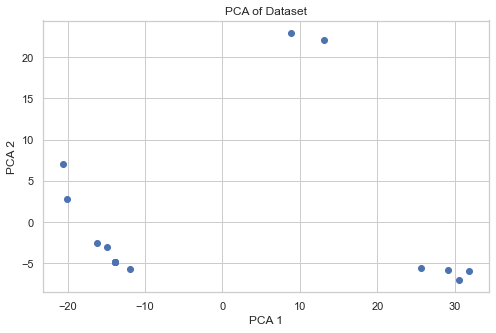

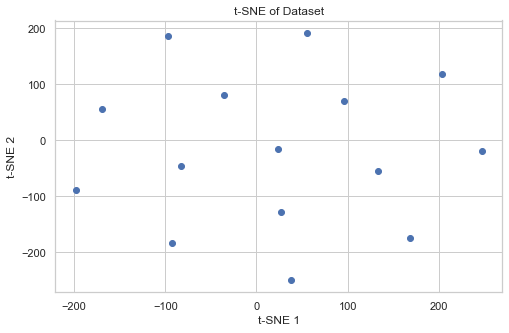

c:\Users\SIBO\AppData\Local\Programs\Python\Python38\lib\site-packages\umap\umap_.py:2433: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


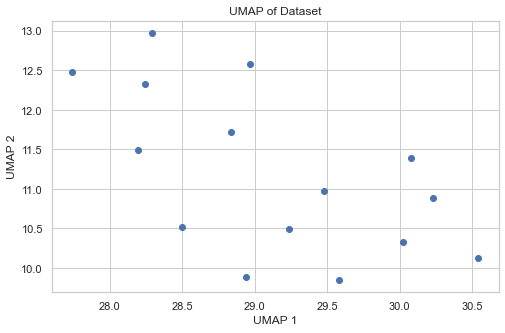

Explained variance by component: [0.4490452  0.30830889]


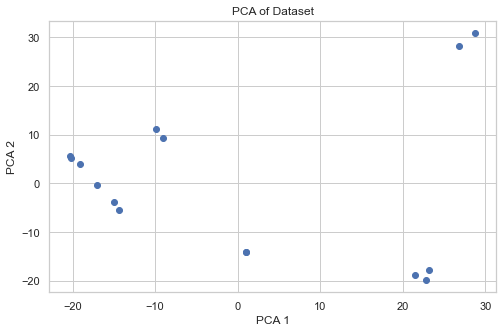

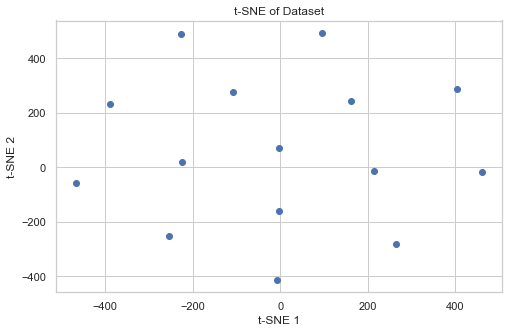

c:\Users\SIBO\AppData\Local\Programs\Python\Python38\lib\site-packages\umap\umap_.py:2433: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


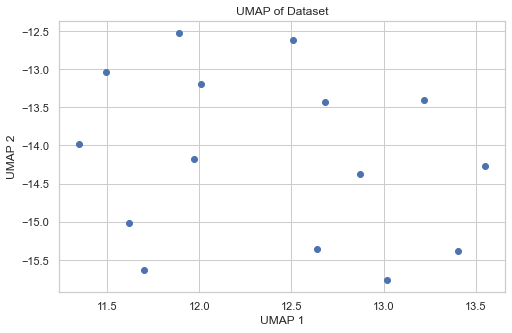

Explained variance by component: [0.48145079 0.21398597]


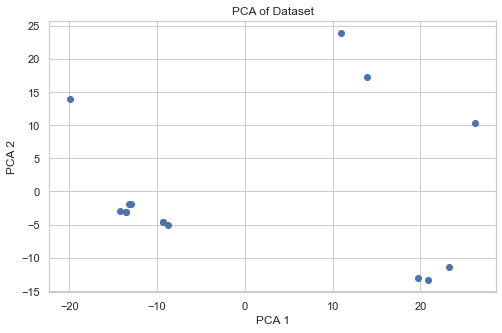

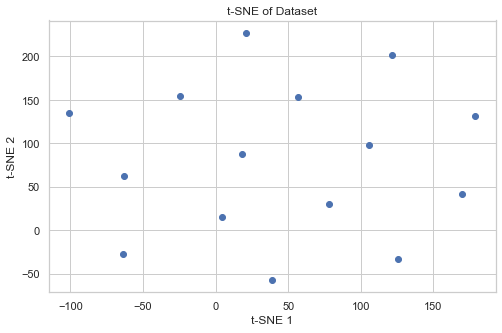

c:\Users\SIBO\AppData\Local\Programs\Python\Python38\lib\site-packages\umap\umap_.py:2433: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


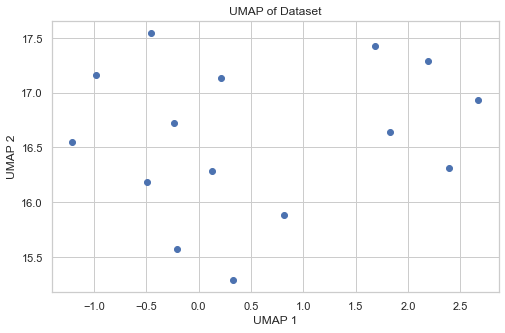

Explained variance by component: [0.40720731 0.36741965]


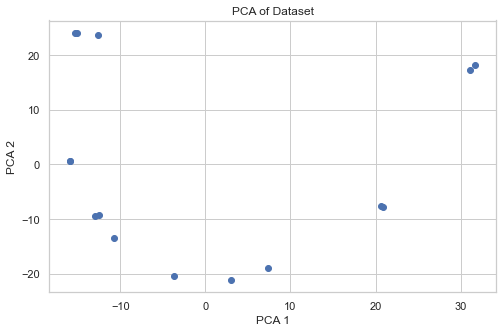

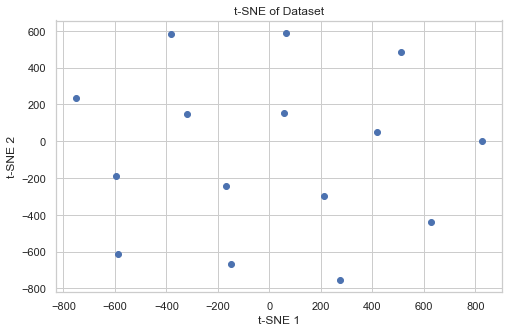

c:\Users\SIBO\AppData\Local\Programs\Python\Python38\lib\site-packages\umap\umap_.py:2433: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


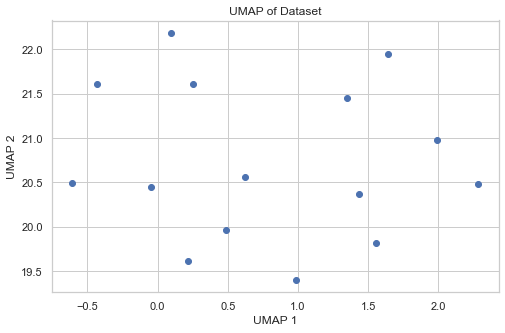

Explained variance by component: [0.39626343 0.33347186]


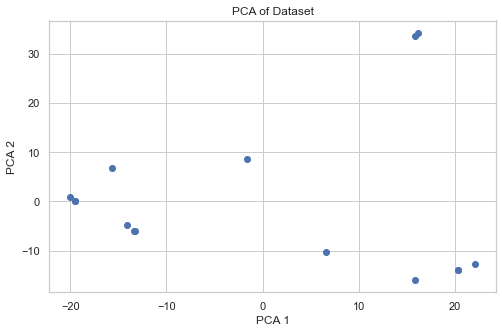

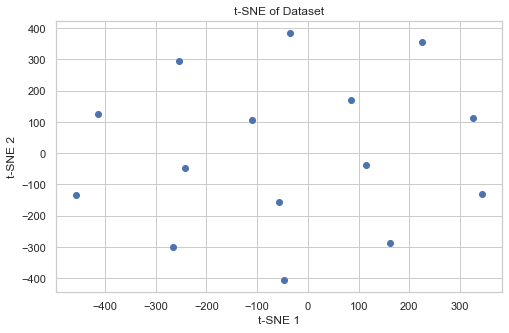

c:\Users\SIBO\AppData\Local\Programs\Python\Python38\lib\site-packages\umap\umap_.py:2433: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


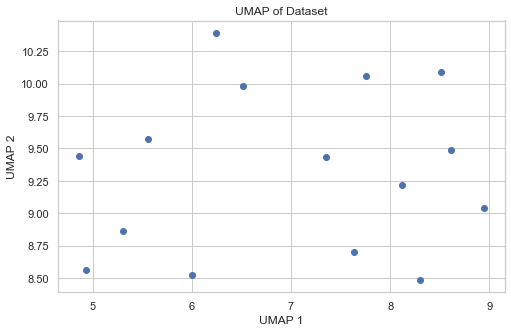

Explained variance by component: [0.37962941 0.31380414]


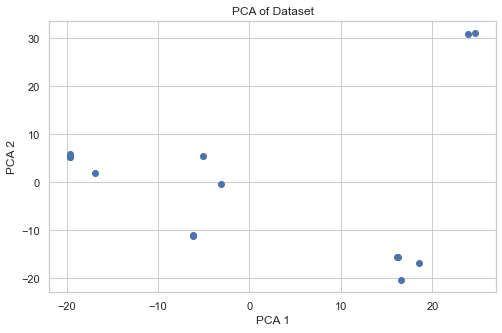

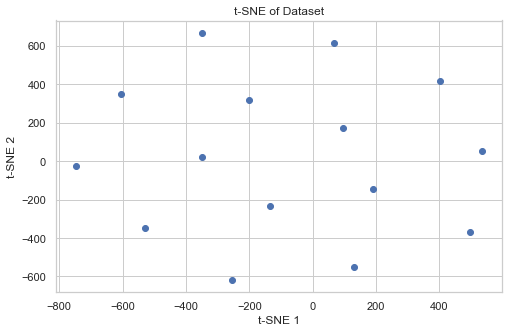

c:\Users\SIBO\AppData\Local\Programs\Python\Python38\lib\site-packages\umap\umap_.py:2433: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


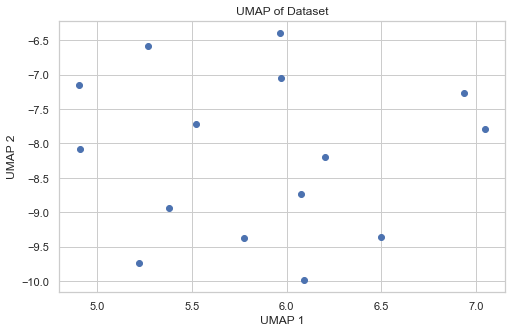

Explained variance by component: [0.40926264 0.28626656]


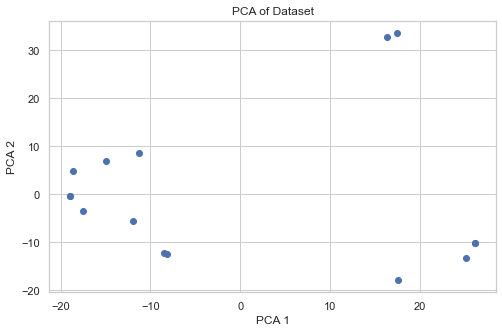

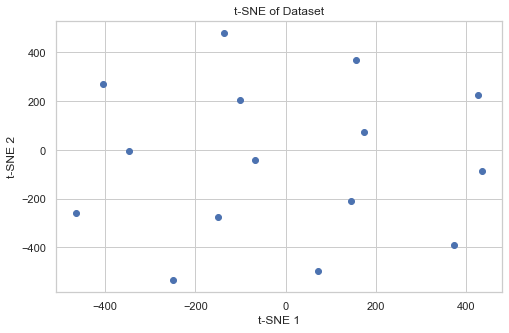

c:\Users\SIBO\AppData\Local\Programs\Python\Python38\lib\site-packages\umap\umap_.py:2433: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


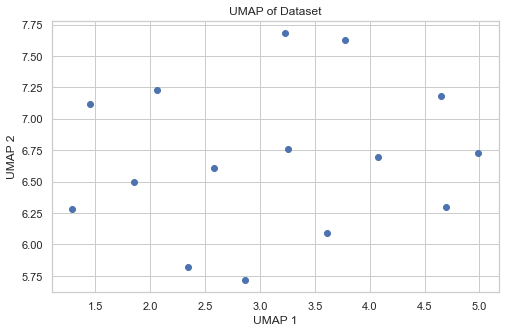

Explained variance by component: [0.37244109 0.27290985]


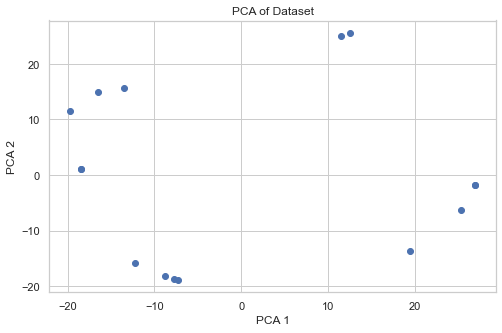

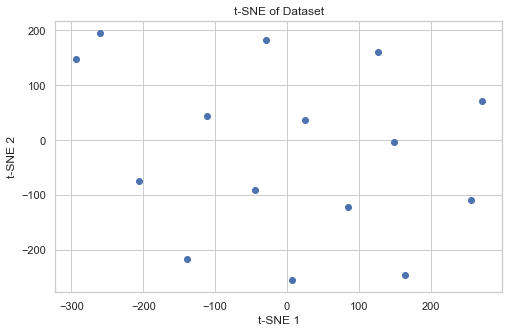

c:\Users\SIBO\AppData\Local\Programs\Python\Python38\lib\site-packages\umap\umap_.py:2433: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


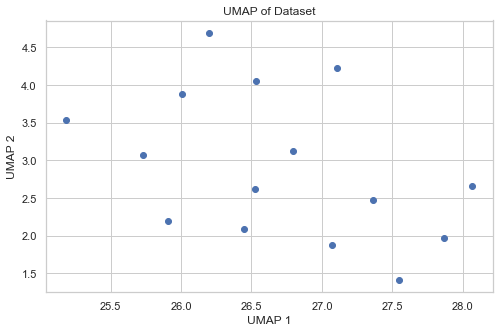

In [182]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler


# Principal Component Analysis (PCA)
def apply_pca(data, n_components=2):
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(data)
    print(f"Explained variance by component: {pca.explained_variance_ratio_}")
    plt.figure(figsize=(8, 5))
    plt.scatter(pca_result[:, 0], pca_result[:, 1])
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.title('PCA of Dataset')
    plt.show()
    return pca_result


# t-Distributed Stochastic Neighbor Embedding (t-SNE)
def apply_tsne(data, n_components=2, perplexity=30.0):
    tsne = TSNE(n_components=n_components, perplexity=perplexity)
    tsne_result = tsne.fit_transform(data)
    plt.figure(figsize=(8, 5))
    plt.scatter(tsne_result[:, 0], tsne_result[:, 1])
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.title('t-SNE of Dataset')
    plt.show()
    return tsne_result

# Uniform Manifold Approximation and Projection (UMAP)
def apply_umap(data, n_components=2, n_neighbors=15, min_dist=0.1):
    reducer = umap.UMAP(n_components=n_components, n_neighbors=n_neighbors, min_dist=min_dist)
    umap_result = reducer.fit_transform(data)
    plt.figure(figsize=(8, 5))
    plt.scatter(umap_result[:, 0], umap_result[:, 1])
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.title('UMAP of Dataset')
    plt.show()
    return umap_result



scaler = StandardScaler()

# For better plot aesthetics
sns.set(style='whitegrid')

features_to_plot = ['CPU cores', 'CPU usage [%]', 'Memory capacity provisioned [KB]', 'Memory usage [KB]', 
                   'Disk read throughput [KB/s]', 'Disk write throughput [KB/s]', 
                   'Network received throughput [KB/s]', 'Network transmitted throughput [KB/s]']

# A function to scale the "Value" column of each group
def scale_values(group):
    group['Scaled_Value'] = scaler.fit_transform(group[['Value']])
    return group

# Apply the scaling function to each group
scaled_df = flattened_df.groupby(['Feature', 'Statistic']).apply(scale_values)

def group_df(group):
    #return pd.Series(group['Scaled_Value'].values)
    return np.array(group['Scaled_Value'].values)

grouped_df = scaled_df.groupby(['Feature', 'Statistic']).apply(group_df)



for feature in features_to_plot:
    feature_df = grouped_df[feature]

    new_arr = np.array(feature_df.values.tolist())

    #replace NaN with 0
    new_arr = np.nan_to_num(new_arr)

    pca_result = apply_pca(new_arr)
        
    tsne_result = apply_tsne(new_arr)

    umap_result = apply_umap(new_arr)




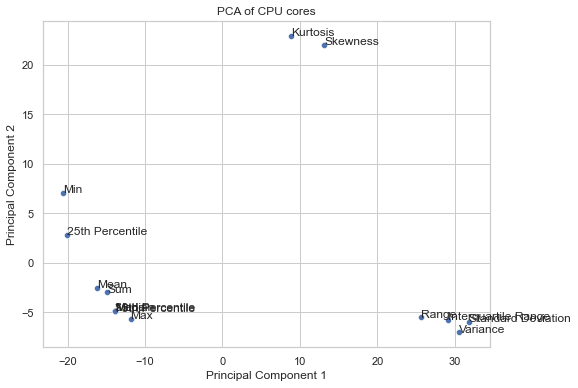

Explained variance by component for 'CPU cores': [0.69811879 0.15987165]


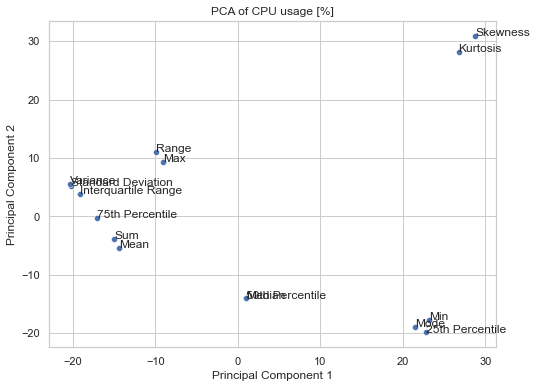

Explained variance by component for 'CPU usage [%]': [0.4490452  0.30830889]


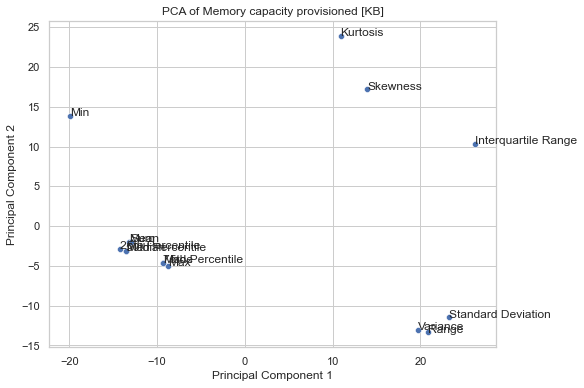

Explained variance by component for 'Memory capacity provisioned [KB]': [0.48145079 0.21398597]


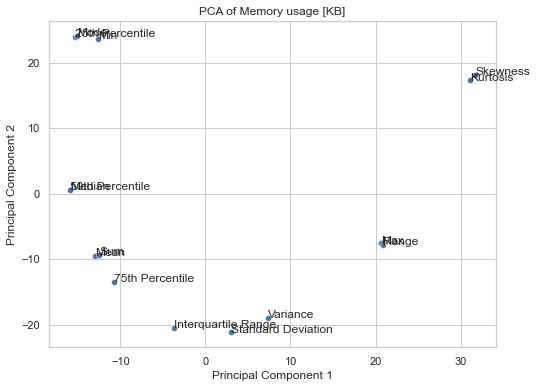

Explained variance by component for 'Memory usage [KB]': [0.40720731 0.36741965]


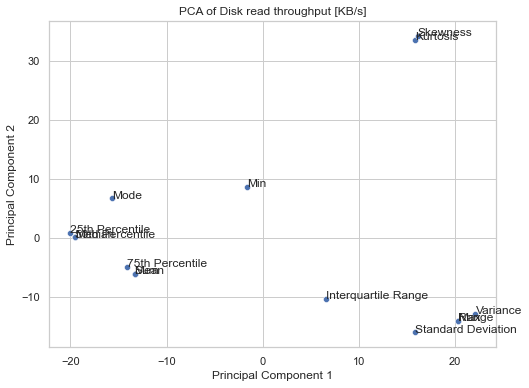

Explained variance by component for 'Disk read throughput [KB/s]': [0.39626343 0.33347186]


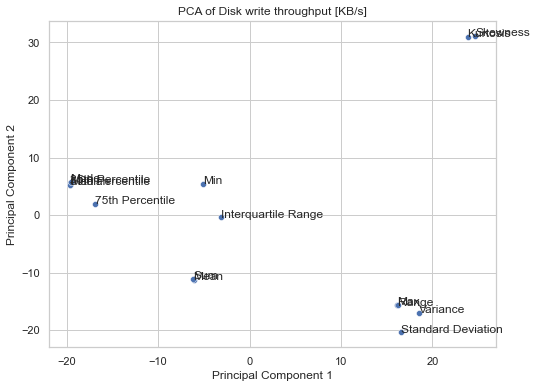

Explained variance by component for 'Disk write throughput [KB/s]': [0.37962941 0.31380414]


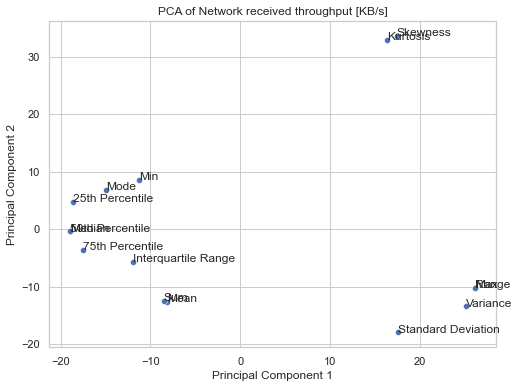

Explained variance by component for 'Network received throughput [KB/s]': [0.40926264 0.28626656]


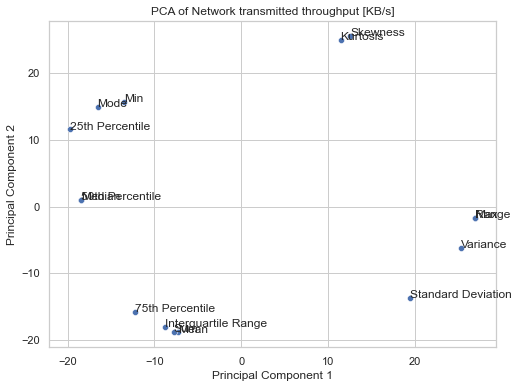

Explained variance by component for 'Network transmitted throughput [KB/s]': [0.37244109 0.27290985]


In [181]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# For better plot aesthetics
sns.set(style='whitegrid')

features_to_plot = ['CPU cores', 'CPU usage [%]', 'Memory capacity provisioned [KB]', 'Memory usage [KB]', 
                   'Disk read throughput [KB/s]', 'Disk write throughput [KB/s]', 
                   'Network received throughput [KB/s]', 'Network transmitted throughput [KB/s]']

# A function to scale the "Value" column of each group
def scale_values(group):
    group['Scaled_Value'] = scaler.fit_transform(group[['Value']])
    return group

# Apply the scaling function to each group
scaled_df = flattened_df.groupby(['Feature', 'Statistic']).apply(scale_values)

def group_df(group):
    #return pd.Series(group['Scaled_Value'].values)
    return np.array(group['Scaled_Value'].values)

grouped_df = scaled_df.groupby(['Feature', 'Statistic']).apply(group_df)



for feature in features_to_plot:
    # Filter the DataFrame for the current feature and select only the scaled values
    feature_df = grouped_df[feature]

    new_arr = np.array(feature_df.values.tolist())

    #replace NaN with 0
    new_arr = np.nan_to_num(new_arr)



    # Apply PCA
    pca = PCA(n_components=2)  # Adjust n_components based on your specific needs
    pca_result = pca.fit_transform(new_arr)  # Fill NA values as needed

    # Create a DataFrame with the principal components
    pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
    
    pca_df['Feature'] = feature_df.index.tolist()    


    # Plotting
    plt.figure(figsize=(8, 6))
    plt.title(f'PCA of {feature}')
    
    sns.scatterplot(x='PC1', y='PC2', data=pca_df)
    # add colors to the points in plot based on the feature_df.index.tolist()
    for i, txt in enumerate(feature_df.index.tolist()):
        plt.annotate(txt, (pca_df['PC1'][i], pca_df['PC2'][i]))
        
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()
    
    # Print explained variance
    print(f"Explained variance by component for '{feature}': {pca.explained_variance_ratio_}")

##  1. PCA (Principal Component Analysis)

Explained Variance:  Focus on the explained_variance_ratio_ output from your PCA code.

Example Text Output:

Explained Variance Ratio:
PC1: 0.65    (65% of the variance in the data is captured by the first principal component)
PC2: 0.20    (20% of the variance is explained by the second component)
Interpretation: Components with higher explained variance ratios are more important. In the example above, PC1 is significantly more important than PC2 in representing the original dataset.

Component Loadings: Investigate which original features contribute most heavily to each principal component. Libraries like scikit-learn often have features to directly examine this.

Example Text Output:

Top Loadings for PC1:
   Feature A: 0.85 
   Feature C: 0.45
   Feature B: -0.30  
(Interpret loadings based on what your original features represent)

## 2. t-SNE (t-Distributed Stochastic Neighbor Embedding)

Cluster Visualization: t-SNE is primarily used for visualization in 2D/3D. Examine the scatterplot carefully:

Are there distinct clusters of data points?
Do the clusters seem related or well-separated?
Qualitative Analysis: Since t-SNE doesn't directly translate to feature importance, the analysis is descriptive:

Example Text Output:

The t-SNE plot exhibits several distinct clusters. One large cluster is in the upper right, a smaller, denser cluster in the lower left, and some loosely scattered points between. This suggests potential underlying structure within the dataset.

##  3. UMAP (Uniform Manifold Approximation and Projection)

Cluster Visualization:  Similar to t-SNE, look for:

Cluster patterns (separation, density)
Outliers or isolated points
Preservation of Relationships:  UMAP tries to maintain some of the global structure of the dataset in its lower-dimensional embedding.

Example Text Output:

UMAP shows a defined cluster structure. Compared to t-SNE, the two main clusters seem closer together, potentially indicating greater similarity between those samples in the original high-dimensional space.